In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import io
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
  
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_msssim import ssim, ms_ssim

from typing import List
from masks import ring_mask, box_mask, dot_mask
from load_compression_models import (
    my_bmshj2018_factorized, 
    my_bmshj2018_factorized_relu,
    my_bmshj2018_hyperprior,
    my_cheng2020_anchor,
    my_cheng2020_attn,
    my_mbt2018,
    my_mbt2018_mean
)
from compressai.losses import RateDistortionLoss

In [2]:
# Disable TF32 Tensor Cores
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

### Load the Compression Networks

In [3]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    'mps'

In [4]:
models = {
    'my_bmshj2018_factorized_relu': my_bmshj2018_factorized_relu(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_bmshj2018_factorized'     : my_bmshj2018_factorized(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_bmshj2018_hyperprior'     : my_bmshj2018_hyperprior(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_cheng2020_anchor'         : my_cheng2020_anchor(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_cheng2020_attn'           : my_cheng2020_attn(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_mbt2018'                  : my_mbt2018(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_mbt2018_mean'             : my_mbt2018_mean(quality=2, pretrained=True).train().to(torch.float32).to(device)
}
net = models['my_bmshj2018_factorized_relu']
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


### Load the Dataset

In [5]:
# Define the transformations
img_WH = 256
transform = transforms.Compose([
    transforms.Resize((img_WH, img_WH)),
    transforms.ToTensor(),
])

# Load the CelebA dataset
dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


### Run Attack

In [6]:
class StatsMeter:
    # Utility function to track statistics of a variable
    # over time
    def __init__(self) -> None:
        self.data = []
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.max = 0
        self.min = float('inf')

    def update(self, val : float, n : int = 1) -> None:
        self.count += n
        self.data.append(val)
        self.sum = sum(self.data)
        self.avg = self.sum / len(self.data)
        self.max = max(self.data)
        self.min = min(self.data)

In [7]:
class CustomLRScheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: torch.optim.Optimizer, 
                 update_every: int = 1000, 
                 update_factor: int = 10, 
                 last_epoch: int = -1):
        self.update_every = update_every
        self.update_factor = update_factor
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        # Change the learning rate every 'reduce_every' epochs
        if (self.last_epoch + 1) % self.update_every == 0:
            return [group['lr'] / self.update_factor for group in self.optimizer.param_groups]
        else:
            return [group['lr'] for group in self.optimizer.param_groups]

In [8]:
def loss_fn(src: torch.Tensor, target: torch.Tensor, iter: int, num_steps: int) -> torch.Tensor:
    if iter < num_steps // 2:
        mse = F.mse_loss(src, target) 
        cos_sim = F.cosine_similarity(src.view(1, -1), target.view(batch_size, -1), dim=1).mean()
        loss = mse + ((1 - cos_sim) / 2)
    else:
        loss = torch.dist(src, target, p=float('inf'))
    return loss

In [10]:
class Attack:
    def __init__(
            self, 
            model: torch.nn.Module, 
            criterion: loss_fn,
            batch_size: int
        ):
        self.model = model
        self.criterion = criterion
        self.batch_size = batch_size

        # Evaluation metrics
        self.success = []
        self.psnr = []
        self.ssim = []
        self.l2 = []

    def run(
            self,
            src_img: torch.Tensor, 
            target_img: torch.Tensor, 
            optimizer: torch.optim.Optimizer, 
            scheduler: torch.optim.lr_scheduler._LRScheduler, 
            num_steps: int, 
            mask: torch.Tensor = None
        ) -> List:
        # Move images to the same device as the model
        src_img = src_img.to(device)
        target_img = target_img.to(device)
        mask = mask.to(device)
        # Get the embedding of the source image and make a copy of the target
        src_emb = self.model.forward(src_img)['y_hat']

        # Track the best performance
        best_img = None
        loss_tracker = StatsMeter()

        pbar = tqdm(range(num_steps))
        for iter in pbar:  
            out = self.model.forward(target_img)
            target_emb = out['y_hat']
            loss = self.criterion(src_emb, target_emb, iter, num_steps)
            pbar.set_description(f"[Running attack]: Loss {loss.item()}")

            optimizer.zero_grad()
            target_img.grad,  = torch.autograd.grad(loss, [target_img])
            # loss.backward(retain_graph=True)
            if mask is not None:
                target_img.grad *= mask
            optimizer.step()
            scheduler.step()
            loss_tracker.update(loss.item())

            # Save the image that achieved the best performance
            if loss.item() == loss_tracker.min:
                best_img = target_img

        return best_img, loss_tracker
    
    def batch_eval(self, x, x_adv):
        with torch.no_grad():
            output = net.forward(x_adv)['x_hat']
        success = self._calculate_success_rate(x, x_adv)
        metrics = self._calculate_psnr_ssim_l2(x, output)

        self.success.append(success)
        self.l2.append(metrics['l2'])
        self.ssim.append(metrics['ssim'])
        self.psnr.append(metrics['psnr'])
        print(f"BATCH METRICS\nSuccess: {success}/{self.batch_size}\nNormalized L2 Dist: {metrics['l2']}\nSSIM: {metrics['ssim']}\nPSNR: {metrics['psnr']}\n")

    def global_eval(self):
        def calculate(metric):
            return sum(metric) / len(metric)
        asr = calculate(self.success) / self.batch_size
        l2 = calculate(self.l2)
        ssim = calculate(self.ssim)
        psnr = calculate(self.psnr)
        print(f"\nGLOBAL METRICS\nSuccess: {asr}\nNormalized L2 Dist: {l2}\nSSIM: {ssim}\nPSNR: {psnr}")

    def _calculate_success_rate(self, src_img, adv_imgs):
        success = 0
        # Calculate the hamming distance between the compressed x and x_adv
        with torch.no_grad():
            src_bytes = net.compress(src_img)['strings'][0][0]
            x_adv_bytes = net.compress(adv_imgs)['strings'][0]
        for adv_bytes in x_adv_bytes:
            hamming_dist = 0
            if len(adv_bytes) != len(src_bytes):
                continue
            for x_byte, adv_byte in zip(src_bytes, adv_bytes):
                hamming_dist += bin(x_byte^adv_byte).count('1')
            normalized_hamming_dist = hamming_dist / (len(src_bytes) * 8)
            if hamming_dist == 0:
                success += 1
        return success
    
    def _calculate_psnr_ssim_l2(self, img1, img2):
        def _psnr(img1, img2, max_val=1.0):
            # img1 and img2 should be of shape (batch_size, channels, height, width) and normalized to [0, 1] range
            mse = F.mse_loss(img1, img2)
            psnr = 10 * torch.log10(max_val / torch.sqrt(mse))
            return psnr
        normalized_l2_dist, struct_sim, psnr = [], [], []
        for i in range(batch_size):
            normalized_l2_dist.append(torch.norm(img1 - img2[i]) / img1.numel())
            struct_sim.append(ssim(img1, img2[i].unsqueeze(0)))
            psnr.append(_psnr(img1, img2[i]))
        return {
            'l2': torch.tensor(normalized_l2_dist).mean(),
            'ssim': torch.tensor(struct_sim).mean(),
            'psnr': torch.tensor(psnr).mean()
        }

In [11]:
num_steps = 10000
mask_type = 'dot'
#success, asr = 0, 0
num_batches = 2
# Source Image and its compressed bytes
x = dataset[0][0].unsqueeze(0).to(device)
with torch.no_grad():   
    x_bytes = net.compress(x)['strings'][0][0]
# Initialize the attack
attack = Attack(model=net, criterion=loss_fn, batch_size=batch_size)
for i, (x_hat, _) in enumerate(dataloader):
    x_hat = x_hat.to(device)
    x_src = x_hat.clone()
    x_hat.requires_grad = True
    if mask_type == 'box':
        lr = 3e-3
        mask = box_mask()
    elif mask_type == 'ring':
        lr = 3e-3
        num_rings = 50
        ring_width = 1
        ring_separation = 5
        mask = ring_mask(x_hat, num_rings=num_rings, ring_width=ring_width, ring_separation=ring_separation)
    elif mask_type == 'dot':
        lr = 5e-2
        vertical_skip = 2 
        horizontal_skip = 3
        mask = dot_mask(x_hat, vertical_skip=vertical_skip, horizontal_skip=horizontal_skip)

    # Run the attack and produce an adversarial image y_hat
    optimizer = torch.optim.Adam([x_hat], lr=lr)
    scheduler = CustomLRScheduler(optimizer, update_every=num_steps // 2, update_factor=1000)
    x_adv, loss_tracker = attack.run(x, x_hat, optimizer=optimizer, scheduler=scheduler, num_steps=num_steps, mask=mask)
    #x_adv, loss_tracker = pgd(x, x_hat, model=net, optimizer=optimizer, scheduler=scheduler, num_steps=num_steps, mask=mask)

    # Pass the adv image through the compression network and see the result
    with torch.no_grad():
        output = net.forward(x_adv)['x_hat']

    # Evaluate the performance of the attack on this batch of data
    attack.batch_eval(x, x_adv)    
    if i == num_batches - 1:
        break

# Evaluate the performance of the attack across the entire dataset
attack.global_eval()

[Running attack]: Loss 0.057562652975320816: 100%|██████████| 10000/10000 [13:31<00:00, 12.32it/s] 


BATCH METRICS
Success: 28/32
Normalized L2 Dist: 9.562441846355796e-05
SSIM: 0.9999362826347351
PSNR: 13.726323127746582


[Running attack]: Loss 0.06238285452127457: 100%|██████████| 10000/10000 [13:33<00:00, 12.30it/s]  


BATCH METRICS
Success: 24/32
Normalized L2 Dist: 9.55851428443566e-05
SSIM: 0.9999364614486694
PSNR: 13.728109359741211
GLOBAL METRICS
Success: 0.8125
Normalized L2 Dist: 9.560478065395728e-05
SSIM: 0.9999363422393799
PSNR: 13.727216720581055


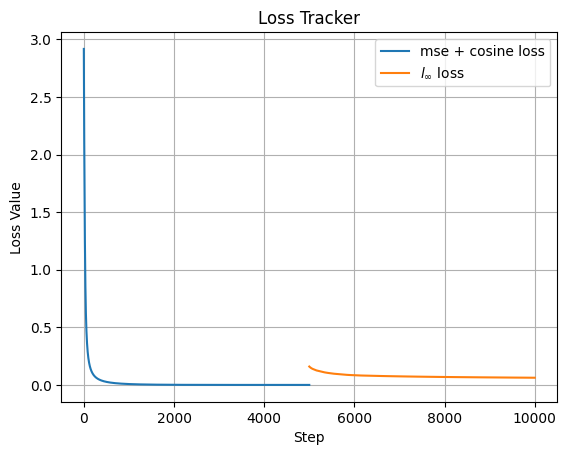

In [14]:
# Show how the loss changed during optimization
plt.plot(torch.linspace(0, num_steps//2, num_steps//2), loss_tracker.data[:num_steps//2], label='mse + cosine loss')
plt.plot(torch.linspace(num_steps//2, num_steps, num_steps//2), loss_tracker.data[num_steps//2:], label = '$l_{\infty}$ loss')
plt.xlabel('Step')
plt.ylabel('Loss Value')
plt.title('Loss Tracker')
plt.legend()
plt.grid()
plt.show()

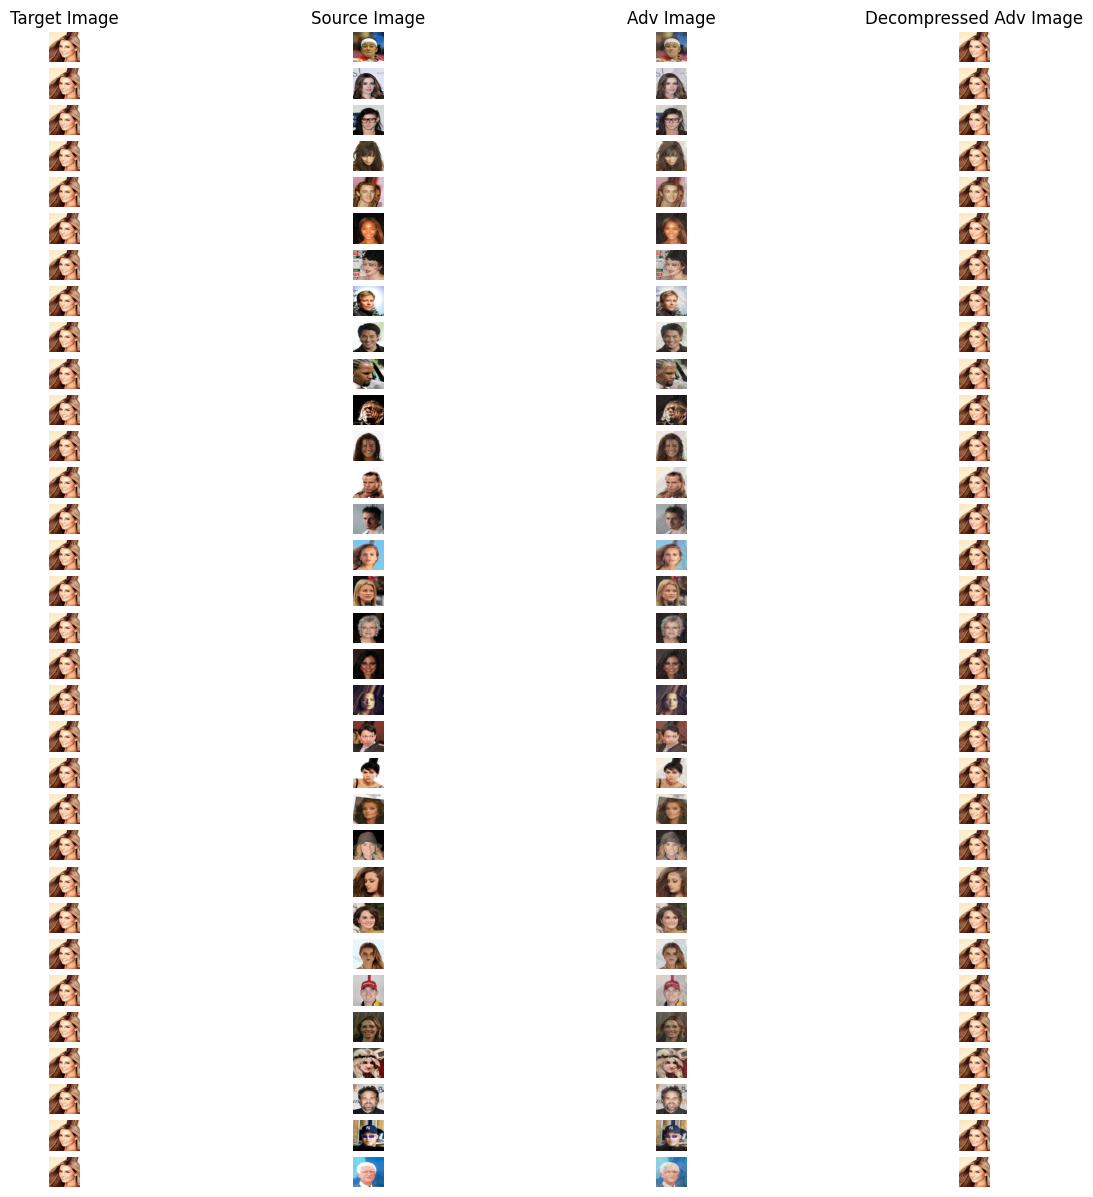

In [15]:
# Create a figure to hold the subplots
fig, axs = plt.subplots(batch_size, 4, figsize=(15, 15))  # num_sources rows, 4 columns
labels = ['Target Image', 'Source Image', 'Adv Image', 'Decompressed Adv Image']

for idx in range(batch_size):
    images = [x, x_src[idx], x_adv[idx], output[idx]]
    
    # Iterate over the images and axes to plot each image
    for img_idx, ax in enumerate(axs[idx] if batch_size > 1 else axs):  # Use idx for outer loop, img_idx for inner
        img = images[img_idx].clip(0, 1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Change the shape to [H, W, C]
        ax.imshow(img)
        if idx == 0:
            ax.set_title(labels[img_idx])
        ax.axis('off')  # Hide axis

plt.show()

### Performance Metrics

Similarity between the adversarial output of the network and the target image

In [16]:
def calculate_psnr(img1, img2, max_val=1.0):
    # img1 and img2 should be of shape (batch_size, channels, height, width) and normalized to [0, 1] range
    mse = F.mse_loss(img1, img2)
    psnr = 10 * torch.log10(max_val / torch.sqrt(mse))
    return psnr

In [17]:
# Pass the adv image through the compression network and see the result
with torch.no_grad():
    output = net.forward(x_adv)['x_hat']

In [18]:
normalized_l2_dist, struct_sim, psnr = [], [], []
for i in range(batch_size):
    normalized_l2_dist.append(torch.norm(x - output[i]) / (3 * img_WH * img_WH))
    struct_sim.append(ssim(x, output[i].unsqueeze(0)))
    psnr.append(calculate_psnr(x, output[i]))

print(f'Normalized L2 Dist: {torch.tensor(normalized_l2_dist).mean()}\nSSIM: {torch.tensor(struct_sim).mean()}\nPSNR: {torch.tensor(psnr).mean()}')


Normalized L2 Dist: 9.563431376591325e-05
SSIM: 0.9999365210533142
PSNR: 13.725875854492188


Similarity between the source image and the adversarial image

In [19]:
normalized_l2_dist, struct_sim, psnr = [], [], []
for i in range(batch_size):
    normalized_l2_dist = torch.norm(x_src[i] - x_adv[i]) / (3 * img_WH * img_WH)
    struct_sim = ssim(x_src[i].unsqueeze(0), x_adv[i].unsqueeze(0))
    psnr = calculate_psnr(x_src[i], x_adv[i])

print(f'Normalized L2 Dist: {torch.tensor(normalized_l2_dist).mean()}\nSSIM: {torch.tensor(struct_sim).mean()}\nPSNR: {torch.tensor(psnr).mean()}')


Normalized L2 Dist: 0.004260556772351265
SSIM: 0.9200407862663269
PSNR: -2.762669324874878


### Interpolate between Source and Adv Images

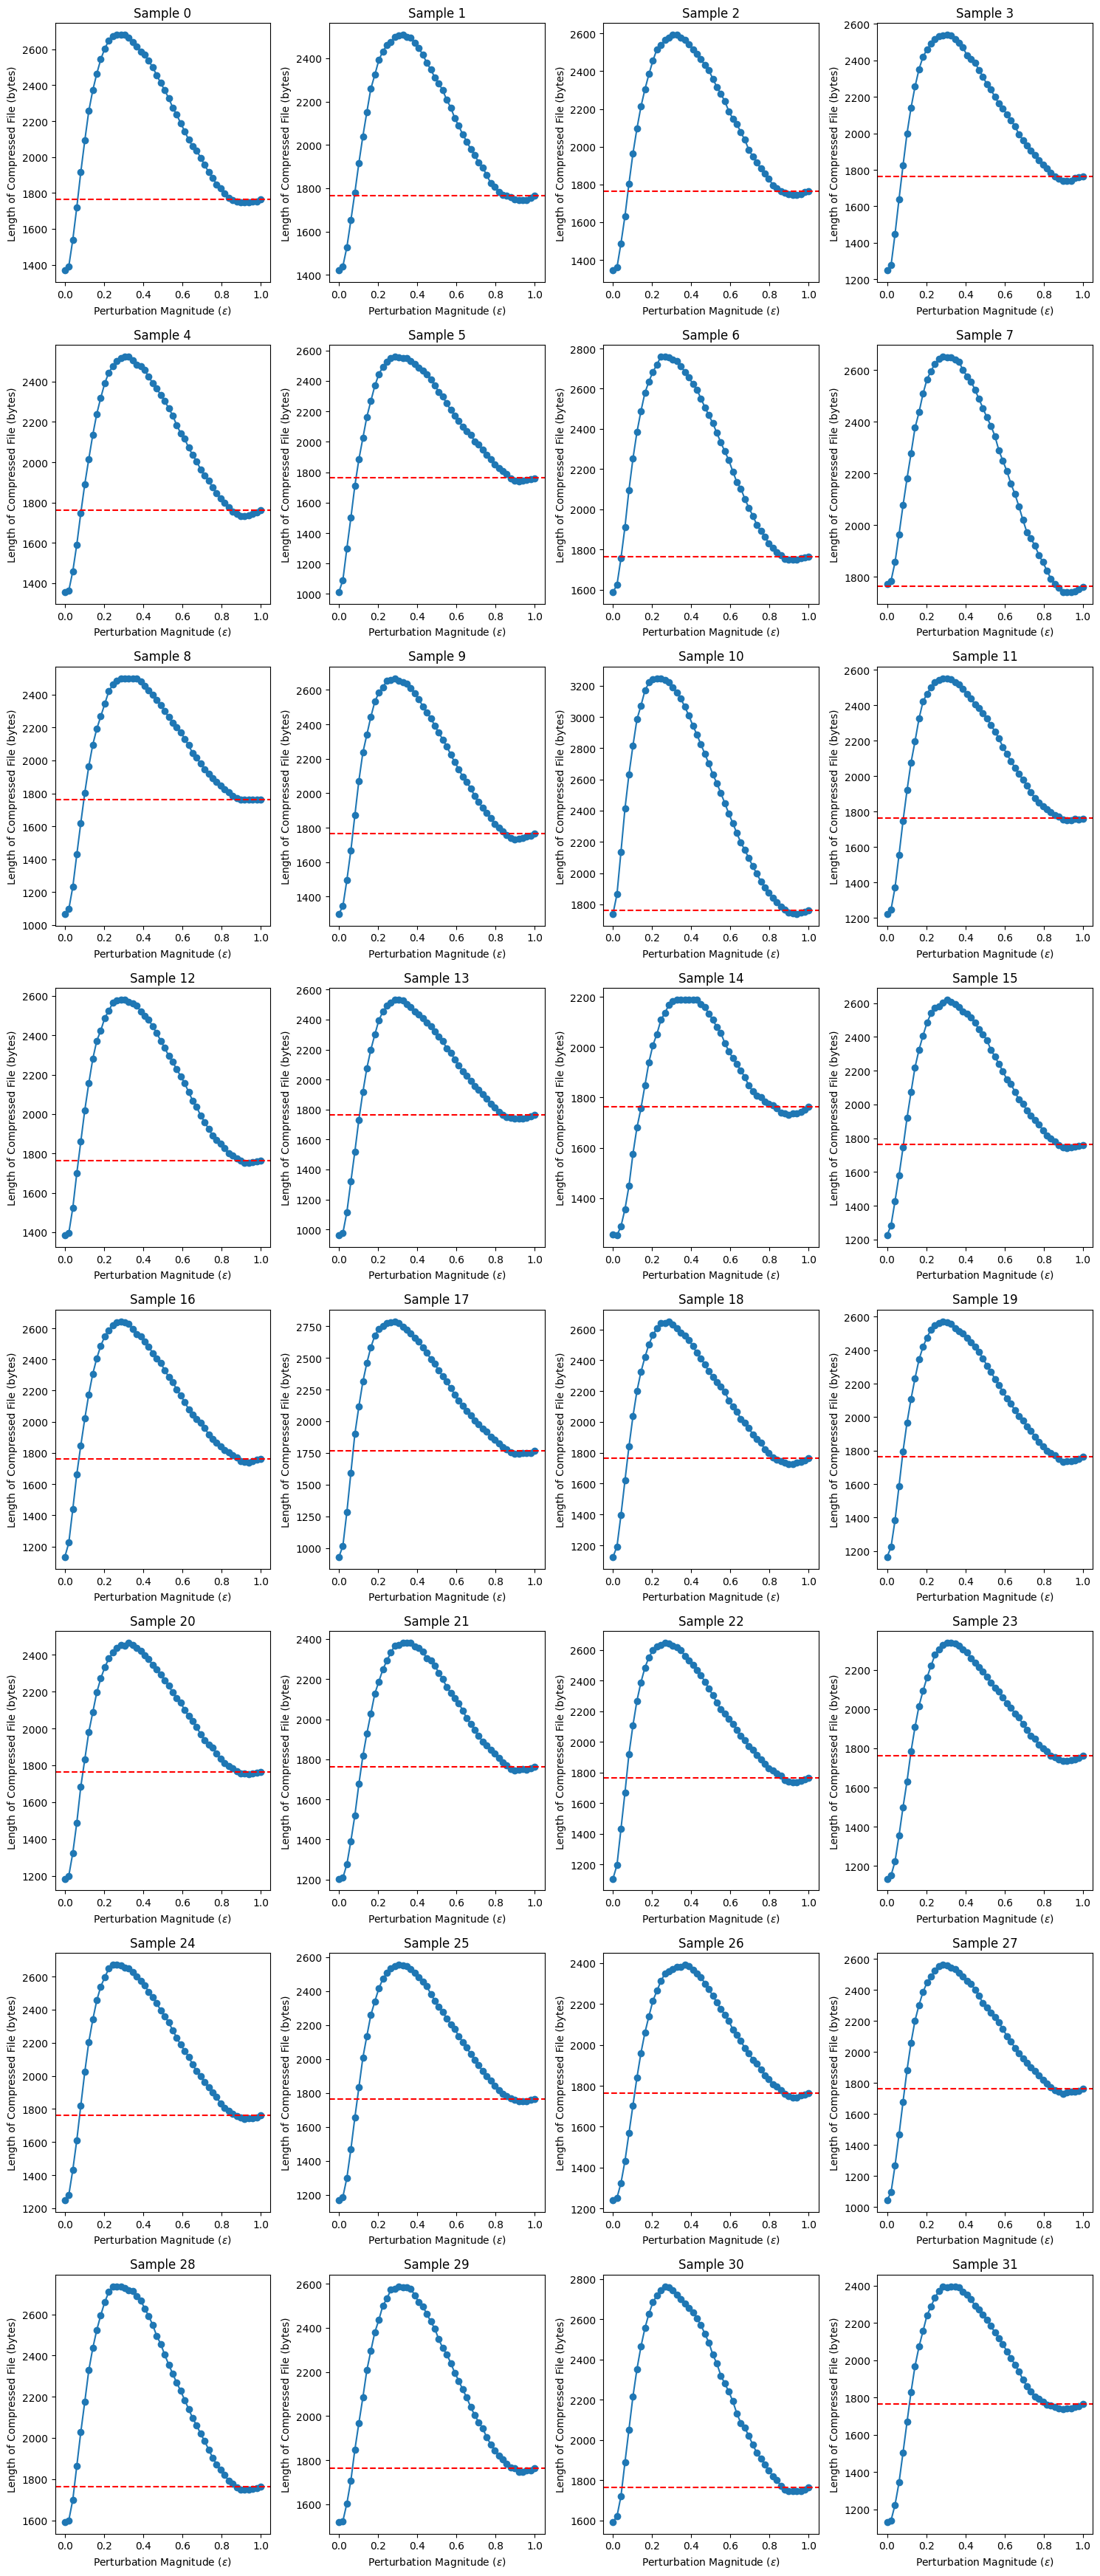

In [20]:
fig, axs = plt.subplots(batch_size // 4, 4, figsize=(15, 35))  

# Flatten axs if it's a 2D array to make indexing easier
axs = axs.ravel() if batch_size > 1 else [axs]

for idx in range(batch_size):
    # Interpolate between the source and adversarial images
    intermediate_imgs = []
    outputs = []
    sample_number = idx      # which image from the batch to visualize
    intervals = torch.linspace(0, 1, 50)
    
    for val in intervals:
        # Create an interpolated image
        intermediate = val * x_hat[sample_number] + (1 - val) * x_src[sample_number]
        intermediate_imgs.append(intermediate)

        # Pass the interpolated images through the network
        intermediate = intermediate.to(device)  # Move image to the correct device
        intermediate = intermediate.unsqueeze(0) if len(intermediate.shape) == 3 else intermediate
        
        with torch.no_grad():
            output = net(intermediate)
        outputs.append(output['x_hat'].squeeze(0).cpu())  # Assuming 'x_hat' is in the output
    
    # Get the file length of the target image
    x_out = net.compress(x)
    x_len = len(x_out['strings'][0][0])

    # Calculate the file lengths for each interpolated image
    file_lengths = []
    for i in range(len(intermediate_imgs)):
        img = intermediate_imgs[i].unsqueeze(0).to(device)  # Add batch dimension and move to device
        out = net.compress(img)
        file_len = len(out['strings'][0][0])
        file_lengths.append(file_len)

    # Calculate Hamming distance between the target and adversarial image compression
    bytes1 = x_out['strings'][0][0]
    bytes2 = net.compress(x_hat[sample_number].unsqueeze(0).to(device))['strings'][0][0]  # Use the second-to-last intermediate image

    hamming_dist = 0
    for byte1, byte2 in zip(bytes1, bytes2):
        hamming_dist += bin(byte1 ^ byte2).count('1')
    
    normalized_hamming_dist = hamming_dist / (len(bytes1) * 8)

    # Plot the file lengths vs interpolation intervals
    axs[idx].plot(intervals.cpu(), file_lengths, marker='o')
    axs[idx].set_xlabel('Perturbation Magnitude ($\\epsilon$)')
    axs[idx].set_ylabel('Length of Compressed File (bytes)')
    axs[idx].set_title(f'Sample {sample_number}')
    axs[idx].axhline(y=x_len, color='r', linestyle='--', label='Original Image Length')

# Adjust layout to prevent overlapping subplots
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-31.086458..27.127605].


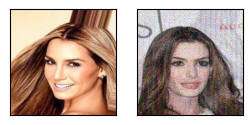

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(3, 3)) 
# Flatten axs if it's a 2D array to make indexing easier
axs = axs.ravel() if batch_size > 1 else [axs]

imgs = [x.squeeze(0).permute(1, 2, 0).detach().cpu().numpy(), x_hat[1].permute(1, 2, 0).detach().cpu().numpy()]
for idx in range(2):
    axs[idx].imshow(imgs[idx])
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
